In [1]:
import numpy as np
import pandas as pd
import math
import random
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
%matplotlib inline

In [2]:
bs = pd.read_csv("./datasets/BS.csv")
#users = pd.read_csv("./datasets/Users.csv")

In [34]:
# Maximum number of phisical resource blocks
MAX_PRB = 25

class User:
    def __init__(self, nprb, nSubcarrier, dfc, f, modOrder, overhead, color, marker):
        
        # Number of pyshical resouce blocks
        self.nprb = nprb
        
        # Number of subcarrier
        self.nSubcarrier = nSubcarrier
        
        # Frequency slice [kHz]
        self.dfc = dfc
        
        # [kHz]
        self.wprb = dfc * nSubcarrier
        
        # [dB]
        self.f = f
        
        # Mod order [bit/sym]
        self.modOrder = modOrder
        
        # Noise [dBm]
        self.noise = -173.977 + f + 10*math.log10(self.wprb*nprb)
        
        # 1 - overhead
        self.overhead = overhead
        
        # Plot color
        self.color = color
        
        # Plot marker
        self.marker = marker
        
        # Bandwidth [kHz]
        self.bandwidth = 4500
        
        # Number of symbol
        self.nSymbol = 13
        
        # Number of symbols for slot
        self.nSymSlot = self.nSymbol/14
        
        # Number of layer (MIMO)
        self.nLayer = 1
                
        # Maximum scaling factor
        self.scalingFactor = 1
        
        # R coding
        self.rCoding = 948/1024
    
    # Gets the maximum bitrate [Mbit/s]
    def getMaxBitRate(self):
        maxBitRate = self.nLayer*self.modOrder*self.scalingFactor*self.rCoding
        maxBitRate *= self.nSymSlot*self.overhead*MAX_PRB
        maxBitRate *= 1000*14*10/1000000
        return maxBitRate
        
    # Compute user throughput
    def computeThroughput():
        return (modOrder * nLayer * nprb * wprb * nSymbol)/1000
        
# Defining l0 (used in path loss computation)
d0 = 1 # m
f = 24 # Gh
l0 = 10*math.log10(((4 * math.pi * d0)/f)**2)

# True: a base station could connect only a user type (IoT or MMB)
isBSExclusive = True

# Creating MMB user
mmbUser = User(9, 12, 15, 4, 6, 1, 'b', ',')

# Creating IoT user
iotUser = User(1, 12, 15, 7, 2, 0.86, 'g', '.')

# Gets user by type
def getUser(type):
    return mmbUser if type == MMB_TYPE else iotUser

# Gets user plot color by type
def getColor(type):
    return getUser(type).color

# Gets user plot marker by type
def getMarker(type):
    return getUser(type).marker

print('Max MMB bit rate is', mmbUser.getMaxBitRate(), '[Mbit/s]')
print('Max IoT bit rate is', iotUser.getMaxBitRate(), '[Mbit/s]')

Max MMB bit rate is 18.052734375000004 [Mbit/s]
Max IoT bit rate is 5.175117187500001 [Mbit/s]


In [35]:
# Number of users to generate
totUsers = 100

# IoT users percent (of totUsers)
iotUsersPercent = 0.8

# MMB users percent (of totUsers)
mmbUsersPercent = 1.0 - iotUsersPercent

# Number of IoT users
numIotUsers = round(totUsers*iotUsersPercent)

# Number of MMB users
numMmbUsers = round(totUsers*mmbUsersPercent)

# Defining types
IOT_TYPE = 'iot'
MMB_TYPE = 'mmb'

# Getting max bs x and y
maxX, maxY = bs.x.max(), bs.y.max()

# Generating users
users = pd.DataFrame()
for r in range(totUsers):
    users.at[r, 'x'] = random.random()*maxX
    users.at[r,'y'] = random.random()*maxY
    if r < numIotUsers:
        users.at[r, 'type'] = IOT_TYPE
    else:
        users.at[r, 'type'] = MMB_TYPE
        
print('Generated', numIotUsers, 'IoT users and', numMmbUsers, 'MMB users')

users.head(totUsers)

Generated 80 IoT users and 20 MMB users


,x,y,type
0,93.822236,203.052580,iot
1,11.308523,94.488982,iot
2,166.634107,163.639495,iot
3,36.618916,31.554607,iot
4,40.038994,261.682006,iot
5,144.776217,218.967262,iot
6,184.535599,71.742451,iot
7,140.370720,81.469135,iot
8,201.475133,70.107904,iot
9,134.688825,263.753652,iot


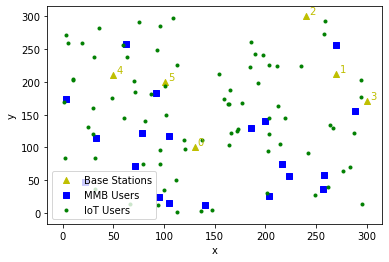

In [36]:
def plotPositions(bs, users, connections = None):

    # Getting MMB/IoT users
    mmbUsers = users[users.type == MMB_TYPE]
    iotUsers = users[users.type == IOT_TYPE]
    
    fig, ax = plt.subplots()
    
    # Plotting BS, MMB and IoT Users positions 
    ax.scatter(bs.y, bs.x, color='y', marker='^')
    ax.scatter(mmbUsers.y, mmbUsers.x, color=getColor(MMB_TYPE), marker=getMarker(MMB_TYPE))
    ax.scatter(iotUsers.y, iotUsers.x, color=getColor(IOT_TYPE), marker=getMarker(IOT_TYPE))
    
    # Plotting labels and legend
    plt.ylabel('y')
    plt.xlabel('x')
    ax.legend(['Base Stations', 'MMB Users', 'IoT Users'])
    
    #Plotting base station indexes
    for i,j in bs.iterrows():        
        ax.annotate(i, (j.y + maxY*0.01, j.x + maxX*0.01), color='y')

    # Plotting user/base station connections
    if(connections is not None):
        for ui, conn  in connections.iterrows():
            if(conn.bsIdx is not None):
                bsi = int(conn.bsIdx)
                
                # Getting user/base station locations
                x1, x2 = users.iloc[conn.uIdx].x, bs.iloc[bsi].x
                y1, y2 = users.iloc[conn.uIdx].y, bs.iloc[bsi].y
            
                if(not math.isinf(x1) and not math.isinf(y1)):
                    ax.plot([y1,y2],[x1,x2], color=getColor(conn.uType), alpha=0.2)
            else:
                # Highlighting users not connected
                pos = (users.loc[int(ui), 'y'], users.loc[int(ui), 'x'])
                circle = plt.Circle(pos, 5, color='r', fill=False, alpha=0.8)
                ax.add_artist(circle)
        
plotPositions(bs, users)

In [37]:
# Computes cartesian distance
def computeDistance(x1, y1, x2, y2):
    return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)

# Computes path loss
def computePathLoss(distance, gamma = 3):
    return l0 + 10*gamma*math.log10(distance)

# Computes path losses for all users/base statiions combinations
def computePathLosses():
    pathLosses = []
    for ui,user in users.iterrows():
        for bsi,base in bs.iterrows():
            
            # Computing distance between user and base station
            dist = computeDistance(user.x, user.y, base.x, base.y)
            
            # Computing path loss between user and base station
            pathLoss = computePathLoss(dist)
            
            pathLosses.append([bsi, ui, user.type, pathLoss])
            
    return pd.DataFrame(pathLosses, columns=['bsIdx', 'uIdx', 'uType', 'pathLoss'])

pathLosses = computePathLosses()
    
pathLosses.head(totUsers*bs.shape[0])

,bsIdx,uIdx,uType,pathLoss
0,0,0,iot,50.278416
1,1,0,iot,58.401895
2,2,0,iot,64.031352
3,3,0,iot,57.151752
4,4,0,iot,62.889940
5,5,0,iot,59.448393
6,0,1,iot,53.814450
7,1,1,iot,67.171963
8,2,1,iot,69.680888
9,3,1,iot,66.832092


In [43]:
# Setting to max the PRB available for the base stations
bs['freePrb'] = MAX_PRB

connections = pd.DataFrame({'uIdx': pathLosses.uIdx.unique()})
connections['bsIdx'] = None
connections['uType'] = None
connections['pathLoss'] = math.inf

userPathLosses = pathLosses.sort_values(by='pathLoss').groupby('uIdx')

# Iterating on user path loss grouped by index 
for uIdx,userPathLoss in userPathLosses:
    # Iterating on single users
    for rowIdx, row in userPathLoss.iterrows():
        
        # Computing free PRB for current base station         
        freePrb = bs.at[row.bsIdx, 'freePrb'] - getUser(str(row.uType)).nprb
        
        if(freePrb >= 0):
            
            # Reducing the available PRB for current base station
            bs.at[row.bsIdx, 'freePrb'] = freePrb
            
            # Allocating current user (uIdx) to current base station (row.bsIdx)
            connections.at[uIdx,'pathLoss'] = row.pathLoss
            connections.at[uIdx,'uType'] = row.uType
            connections.at[uIdx,'bsIdx'] = int(row.bsIdx)
            connections.at[uIdx,'uIdx'] = row.uIdx
            connections.at[uIdx, 'bitRate'] = getUser(row.uType).getMaxBitRate()
            
            #print('User', uIdx, 'allocated to base station', bsIdx, '- free PRB:', freePrb)
            break
        else:
            print('Base station', row.bsIdx, 'PRB full')

connections.head(totUsers)        

Base station 0 PRB full
Base station 0 PRB full
Base station 0 PRB full
Base station 4 PRB full
Base station 5 PRB full
Base station 0 PRB full
Base station 4 PRB full
Base station 5 PRB full
Base station 0 PRB full
Base station 0 PRB full
Base station 5 PRB full
Base station 4 PRB full
Base station 0 PRB full
Base station 3 PRB full
Base station 1 PRB full
Base station 5 PRB full
Base station 4 PRB full
Base station 2 PRB full
Base station 0 PRB full
Base station 3 PRB full
Base station 1 PRB full
Base station 5 PRB full
Base station 4 PRB full
Base station 2 PRB full
Base station 3 PRB full
Base station 1 PRB full
Base station 2 PRB full
Base station 0 PRB full
Base station 5 PRB full
Base station 4 PRB full
Base station 0 PRB full
Base station 5 PRB full
Base station 1 PRB full
Base station 3 PRB full
Base station 4 PRB full
Base station 2 PRB full
Base station 0 PRB full
Base station 5 PRB full
Base station 4 PRB full
Base station 3 PRB full
Base station 1 PRB full
Base station 2 P

,uIdx,bsIdx,uType,pathLoss,bitRate
0,0,0,iot,50.278416,5.175117
1,1,0,iot,53.814450,5.175117
2,2,5,iot,49.962118,5.175117
3,3,0,iot,56.471748,5.175117
4,4,3,iot,58.380585,5.175117
5,5,1,iot,52.221016,5.175117
6,6,5,iot,39.939664,5.175117
7,7,5,iot,48.334245,5.175117
8,8,4,iot,34.535080,5.175117
9,9,3,iot,45.615434,5.175117


In [44]:
print('Network bit rate is', connections.bitRate.sum(), '[Mbit/s]')

bs.head(bs.shape[0])

Network bit rate is 504.2730468750001 [Mbit/s]


,x,y,freePrb
0,100.10,130.33,0
1,212.33,270.11,8
2,300.26,240.21,2
3,170.41,300.20,7
4,210.16,50.11,8
5,200.20,100.80,0


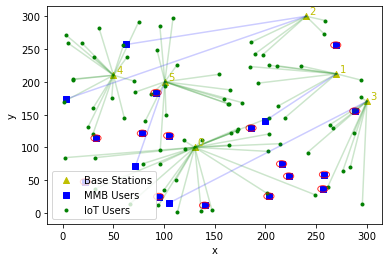

In [46]:
# Plotting users/base stations and related minimum path loss connection
plotPositions(bs, users, connections)